In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import random

In [3]:
names = open('names.txt').read().splitlines()

In [4]:
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
chars = set(''.join(names))
chars.add('.')
n_chars = len(chars)

stoi = {s:i for i,s in enumerate(sorted(chars))}
itos = {i:s for s,i in stoi.items()}

In [6]:
WINDOW_SIZE = 3
def generate_data_examples(name_list):
    X, Y = [], []

    for name in name_list:

        context = [ stoi['.'] ] * WINDOW_SIZE
        for ch in name + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
random.shuffle(names)
n1, n2 = int(0.8*len(names)), int(0.9*len(names))
Xtr, Ytr = generate_data_examples(names[:n1])
Xdev, Ydev = generate_data_examples(names[n1:n2])
Xtest, Ytest = generate_data_examples(names[n2:])

torch.Size([182505, 3]) torch.Size([182505])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22860, 3]) torch.Size([22860])


In [8]:
EMBEDDING_DIMENSIONALITY = 14
NUM_NEURONS = 300

In [9]:
g = torch.Generator().manual_seed(2147483647)

# Embedding matrix, 2d vector space to embed the 27-dimensional character space 
C = torch.randn((n_chars, EMBEDDING_DIMENSIONALITY), generator=g)

# first layer of weights and biases
W1 = torch.randn((WINDOW_SIZE * EMBEDDING_DIMENSIONALITY, NUM_NEURONS), generator=g)
b1 = torch.randn(NUM_NEURONS, generator=g)
# output layer
W2 = torch.randn(NUM_NEURONS, n_chars, generator=g)
b2 = torch.randn(n_chars, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [10]:
sum(p.nelement() for p in parameters)

21405

#### Run for 1000 epochs with a span of learning rates to find a good learning rate

In [206]:
N_EPOCHS = 1000
BATCH_SIZE = 32

learning_rates = torch.logspace(-3, 0, N_EPOCHS)
losses = []
lrrs = []
for iEpoch in range(N_EPOCHS):
    
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))
    # embed
    emb = C[Xtr[ix]]
    # calculate the hidden layer
    h = torch.tanh(emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data += -learning_rates[iEpoch] * p.grad
    
    losses.append(loss.item())    
    
print(loss.item())

16.497116088867188


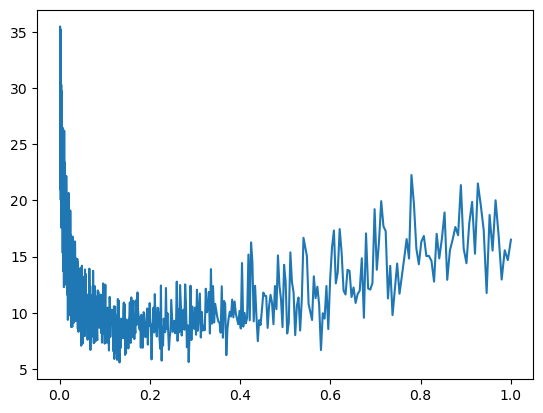

In [207]:
plt.plot(learning_rates, losses)

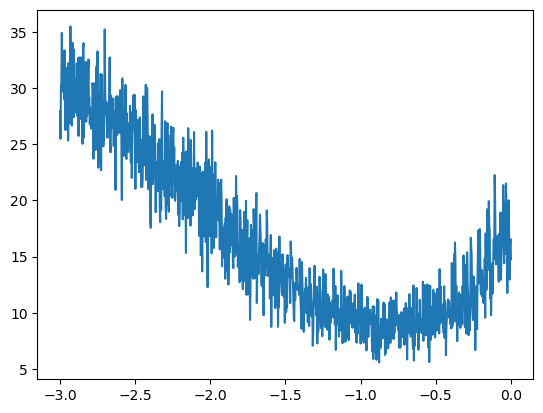

In [208]:
plt.plot(learning_rates.log10(), losses)

#### Good learning rate seems to be 0.1, run long with that rate

In [11]:
lossi = []

In [12]:
N_EPOCHS = 200000
# BATCH_SIZE = 32

for iEpoch in range(N_EPOCHS):
    
    batch_size = 32 if iEpoch < 3*N_EPOCHS / 4 else 128
    lr = 0.1 if iEpoch < N_EPOCHS/2 else 0.01
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    # embed
    emb = C[Xtr[ix]]
    # calculate the hidden layer
    h = torch.tanh(emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -lr * p.grad  
    lossi.append(loss.item())
print(loss.item())

2.0580711364746094


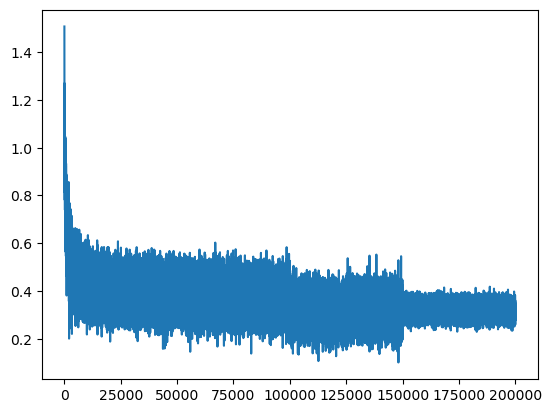

In [13]:
plt.plot(torch.arange(len(lossi)), torch.tensor(lossi).log10())

In [14]:
emb = C[Xtr]
# calculate the hidden layer*
h = torch.tanh(emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(f'training loss: {loss.item()}')

training loss: 2.0966548919677734


In [15]:
emb = C[Xdev]
# calculate the hidden layer
h = torch.tanh(emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(f'dev loss: {loss.item()}')

dev loss: 2.1684675216674805


#### For N_NEURONS = 100; training loss is approximately the same as dev loss after 2 x 10000 epochs with lr = 0.1 and one step of lr decay to lr = 0.01
We're underfitting, our network is not complex enough. Increase N_NEURONS?
Still underfitting with N_NEURONS = 300.

#### Visualize the 2 dimensional embedding of the characters

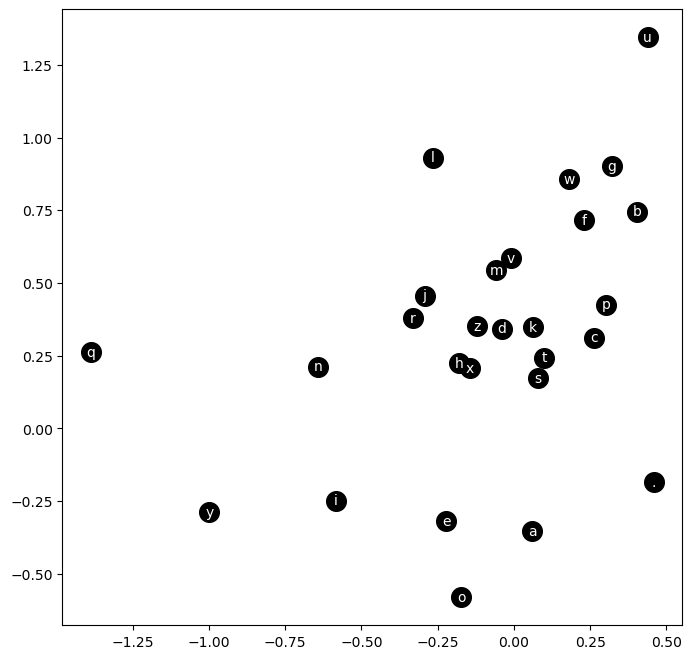

In [142]:
fig = plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200, color='black')
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha="center", va='center', color='white')

plt.show()

# Predict names

In [16]:
N_PREDICTIONS = 10

for iPred in range(N_PREDICTIONS):
    
    prediction = ''
    context = [0]*WINDOW_SIZE
    while True:
        emb = C[context]
        h = torch.tanh(emb.view(-1, WINDOW_SIZE * EMBEDDING_DIMENSIONALITY) @ W1 + b1)
        ix = torch.distributions.Categorical(logits = h @ W2 + b2).sample().item()
        if ix == 0:
            break
        context = context[1:] + [ix]
        prediction += itos[ix]
    print(prediction)

elin
erets
louk
mals
aarius
canluano
haula
rhan
riana
zruontarlos


In [233]:
prediction

'taniyah'